## Assigment 4

In [1]:
import numpy as np
from scipy.linalg import solve_triangular
import cv2
from matplotlib import pyplot as plt
from random import sample, seed
from a4_utils import *
%load_ext autoreload
%autoreload 2
seed(100)

### helper functions

In [2]:
def readGrayF64(path):
    return cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.float64) / 255

In [3]:
def gaussdx(sigma):
    f = lambda x: np.exp(-x**2/(2*sigma**2)) * (-x/(np.sqrt(2*np.pi) * sigma**3))
    r = np.array(list(map(f, np.arange(-3*sigma, 3*sigma+1))))
    return (r / sum(abs(r))).reshape(1, r.shape[0])

def gaussian(sigma):
    f = lambda x: np.exp(-x**2/(2*sigma**2)) / (np.sqrt(2*np.pi) * sigma)
    r = np.array(list(map(f, np.arange(-3*sigma, 3*sigma+1))))
    return (r / sum(r)).reshape(1, r.shape[0])

def g_gdx(o=2):
    if o is None:
        o = 2
    return gaussian(o), -gaussdx(o)

def imgDX(I, o=2):
    g, gdx = g_gdx(o)
    return cv2.filter2D(cv2.filter2D(I, -1, kernel=g.T), -1, kernel=gdx)

def imgDY(I, o=2):
    g, gdx = g_gdx(o)
    return cv2.filter2D(cv2.filter2D(I, -1, kernel=g), -1, kernel=gdx.T)

def imgDXX(I, o=2):
    return imgDX(imgDX(I, o), o)

def imgDXY(I, o=2):
    return imgDY(imgDX(I, o), o)

def imgDYX(I, o=2):
    return imgDX(imgDY(I, o), o)

def imgDYY(I, o=2):
    return imgDY(imgDY(I, o), o)

In [4]:
def nonmaxsuppression(I, nb=1):
    if nb == 0:
        return I

    Is = I.copy()
    box_step = 2*nb
    for y in range(0, Is.shape[0], box_step):
        for x in range(0, Is.shape[1], box_step):
            y_lim = min(y + box_step, Is.shape[0] -1)
            x_lim = min(x + box_step, Is.shape[1] -1)
            neighboruhood = Is[y:y_lim, x:x_lim]
            maxiumum = np.max(neighboruhood)
            maximums = np.argwhere(neighboruhood == maxiumum)
            maximum_index = maximums[len(maximums)//2]
            Is[y:y_lim, x:x_lim] = 0
            Is[y+maximum_index[0], x+maximum_index[1]] = maxiumum
            
    return Is


In [5]:
def hellinger_distance(hist_A, hist_B):
    return np.sum((np.sqrt(hist_A) - np.sqrt(hist_B))**2) ** 0.5 / np.sqrt(2)

### Exercise 1

#### A

In [6]:
def hessian_points(I, o=None, t=None, nb=0):
    Ixx = imgDXX(I, o)
    Iyy = imgDYY(I, o)
    Ixy = imgDXY(I, o)

    detI = np.multiply(Ixx, Iyy) - np.multiply(Ixy, Ixy)

    if t is not None:
        detI[detI < t] = 0
        detI = nonmaxsuppression(detI, nb)
        
    return detI

Text(0.5, 1.0, 'higher sigma')

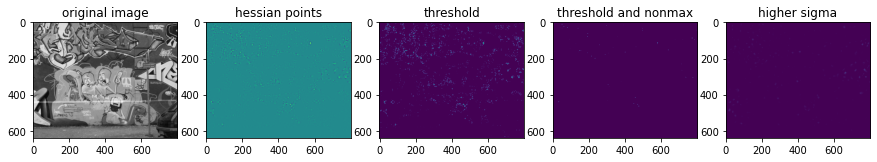

In [7]:
test_points = readGrayF64("./assigments/assigment4/data/graf/graf_a.jpg")
test_points_features = hessian_points(test_points)
test_points_keypoints = hessian_points(test_points, t=0.001)
test_points_keypoints_nonmax = hessian_points(test_points, t=0.01, nb=1)
test_points_keypoints_nonmax2 = hessian_points(test_points, o=6, t=0.001, nb=2)

fig, axes = plt.subplots(1, 5, figsize=(15, 5))

axes[0].imshow(test_points, cmap="gray")
axes[0].set_title("original image")

axes[1].imshow(test_points_features)
axes[1].set_title("hessian points")

axes[2].imshow(test_points_keypoints)
axes[2].set_title("threshold")

axes[3].imshow(test_points_keypoints_nonmax)
axes[3].set_title("threshold and nonmax")

axes[4].imshow(test_points_keypoints_nonmax2)
axes[4].set_title("higher sigma")

In [8]:
def plot_with_keypoints(I, points, axes=None):
    if axes is None:
        _, axes = plt.subplots(1, 1, figsize=(5, 5))
    axes.imshow(I, cmap="gray")
    axes.scatter(points[:, 1], points[:, 0], s=3, c="r")
    axes.set_xlabel("num points: {}".format(len(points)))


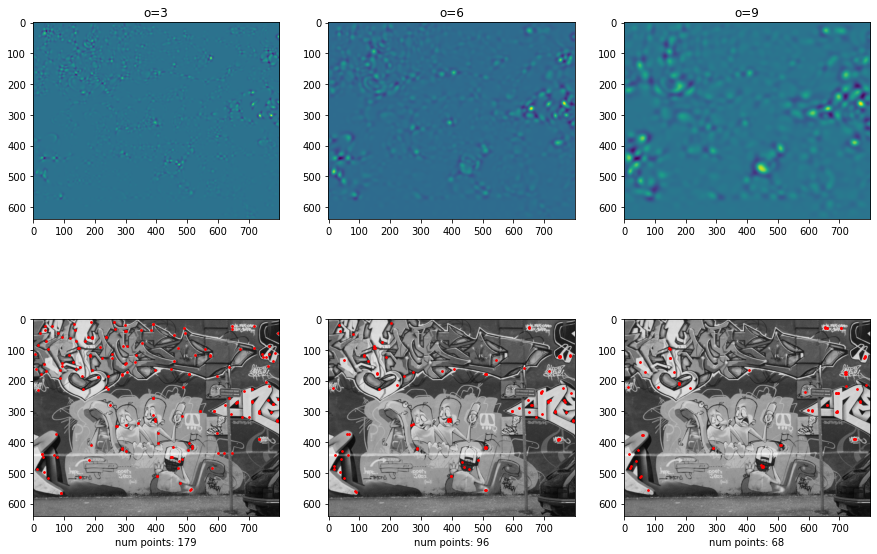

In [9]:
o_options = [3, 6, 9]
t = 0.004
nb = 15

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i in range(len(o_options)):
    points = hessian_points(test_points, o=o_options[i])

    axes[0, i].imshow(points, cmap="viridis")
    axes[0, i].set_title("o={}".format(o_options[i]))

    axes[1, i].imshow(points, cmap="afmhot")
    keypoints = hessian_points(test_points, o=o_options[i], t=t, nb=nb)
    plot_with_keypoints(test_points, np.argwhere(keypoints > 0), axes[1, i])
        

The algorithem detects corners. Parameter sigma affects the size of the gaussian kernel and its derivate, this in turn detects corners on different scales.

#### B

In [10]:
def harris_points(I, o=2, o_after=None, alpha=0.06, t=None, nb=0):
    if o_after is None:
        o_after = 1.6 * o
    afterGK = np.flip(gauss(o_after))
    Ix = imgDX(I, o)
    Iy = imgDY(I, o)
    
    C11 = cv2.filter2D(Ix**2, ddepth=-1, kernel=afterGK)
    C12 = cv2.filter2D(Ix*Iy, ddepth=-1, kernel=afterGK)
    C21 = cv2.filter2D(Iy*Ix, ddepth=-1, kernel=afterGK)
    C22 = cv2.filter2D(Iy**2, ddepth=-1, kernel=afterGK)

    detC = C11*C22 - C12*C21
    traceC = C11 + C22

    value = detC - alpha * (traceC**2)

    if t is not None:
        value[value < t] = 0
        value = nonmaxsuppression(value, nb)
    return value

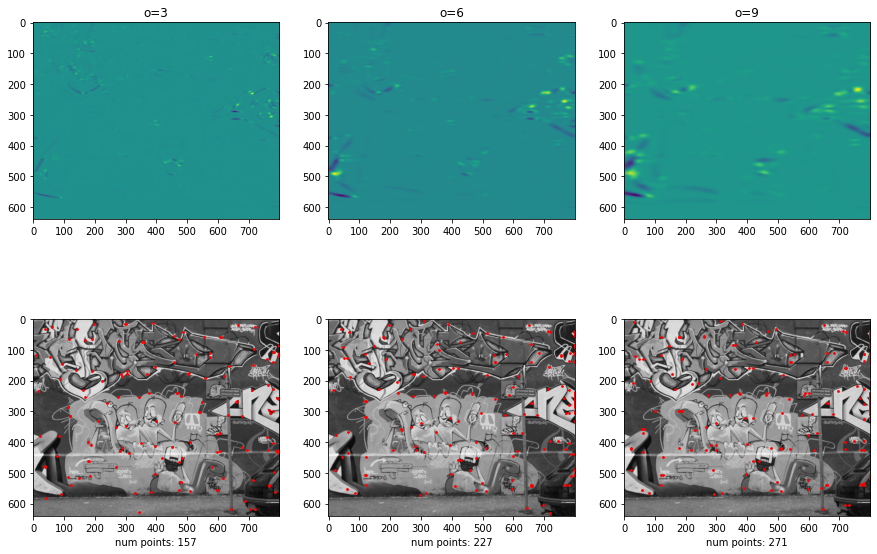

In [11]:
o_options = [3, 6, 9]
t = 10**-6
nb = 30

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i in range(len(o_options)):
    points = harris_points(test_points, o=o_options[i])

    axes[0, i].imshow(points)
    axes[0, i].set_title("o={}".format(o_options[i]))

    axes[1, i].imshow(points)
    keypoints = harris_points(test_points, o=o_options[i], t=t, nb=nb)
    plot_with_keypoints(test_points, np.argwhere(keypoints > 0), axes[1, i])

They appear on similar structures but not exactly the same.

### Exercise 2

#### A

In [12]:
def find_correspondences(descriptorsA, descriptorsB, reverse=False):
    matches = []
    distances = []
    for dAi in range(len(descriptorsA)):
        # default basepoint for comparison
        if not reverse:
            matches.append((dAi, 0))
        else:
            matches.append((0, dAi))
        distances.append(hellinger_distance(descriptorsA[dAi], descriptorsB[0]))

        # find best match for point from A
        for dBi in range(1, len(descriptorsB)):
            distance = hellinger_distance(descriptorsA[dAi], descriptorsB[dBi])
            if distance < distances[-1]:
                if not reverse:
                    matches[-1] = (dAi, dBi)
                else:
                    matches[-1] = (dBi, dAi)
                distances[-1] = distance
    return matches

In [13]:
graf_a_small = readGrayF64("./assigments/assigment4/data/graf/graf_a_small.jpg")
graf_b_small = readGrayF64("./assigments/assigment4/data/graf/graf_b_small.jpg")
graf_a_small.shape, graf_b_small.shape

((289, 340), (289, 340))

In [14]:
graf_a_small_keypoints = np.argwhere(harris_points(graf_a_small, o=6, t=10**-6, nb=10) > 0)
graf_b_small_keypoints = np.argwhere(harris_points(graf_b_small, o=6, t=10**-6, nb=10) > 0)
len(graf_a_small_keypoints), len(graf_b_small_keypoints)

(224, 207)

In [15]:
graf_a_small_descriptors = simple_descriptors(graf_a_small, graf_a_small_keypoints[:, 0], graf_a_small_keypoints[:, 1])
graf_b_small_descriptors = simple_descriptors(graf_b_small, graf_b_small_keypoints[:, 0], graf_b_small_keypoints[:, 1])
len(graf_a_small_descriptors), len(graf_b_small_descriptors)

(224, 207)

In [16]:
graf_a_b_small_correspondences = find_correspondences(graf_a_small_descriptors, graf_b_small_descriptors)
correspondences_indexes = list(zip(*graf_a_b_small_correspondences))

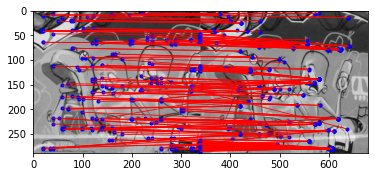

In [17]:
graf_small_a_points_ordered = np.take(graf_a_small_keypoints, correspondences_indexes[0], axis=0)
graf_small_b_points_ordered = np.take(graf_b_small_keypoints, correspondences_indexes[1], axis=0)

display_matches(graf_a_small, graf_small_a_points_ordered, graf_b_small, graf_small_b_points_ordered)

#### B

In [18]:
def simple_descriptors_wrapper(I, Y, X):
    points = np.array((Y, X)).T
    return simple_descriptors(I, Y, X), points

def find_matches(IA, IB, o=6, t=10**-6, nb=10, descriptors=simple_descriptors_wrapper):
    keypoints_A = np.argwhere(harris_points(IA, o=o, t=t, nb=nb) > 0)
    keypoints_B = np.argwhere(harris_points(IB, o=o, t=t, nb=nb) > 0)

    descriptorsA, keypoints_A = descriptors(IA, keypoints_A[:, 0], keypoints_A[:, 1])
    descriptorsB, keypoints_B = descriptors(IB, keypoints_B[:, 0], keypoints_B[:, 1])

    correspondences_A_B = find_correspondences(descriptorsA, descriptorsB)
    correspondences_B_A = find_correspondences(descriptorsB, descriptorsA, reverse=True)

    symetric_correspondences = set(correspondences_A_B).intersection(set(correspondences_B_A))

    correspondences_info = list(zip(*symetric_correspondences))

    points_A_ordered = np.take(keypoints_A, correspondences_info[0], axis=0)
    points_B_ordered = np.take(keypoints_B, correspondences_info[1], axis=0)

    return points_A_ordered, points_B_ordered

In [19]:
pointsA, pointsB = find_matches(graf_a_small, graf_b_small, o=2, t=10**-6, nb=15)
len(pointsA), len(pointsB)

(46, 46)

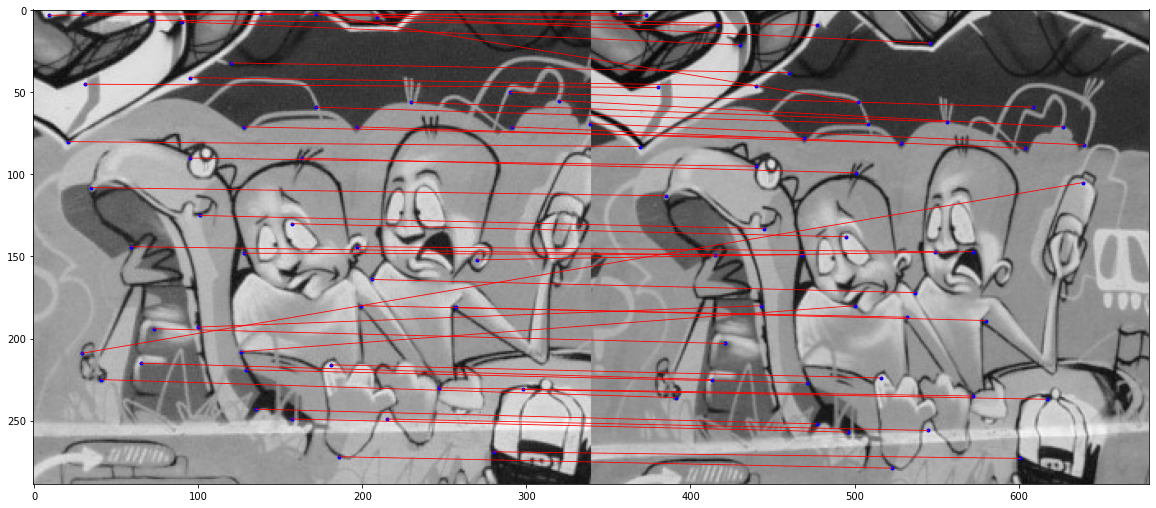

In [20]:
fig = plt.figure(figsize=(20, 10))
display_matches(graf_a_small, pointsA, graf_b_small, pointsB)

The coresponing points are mostly well matched, there are a few outliers, one of which is also not present in the other image. The matching is accurate enough to be used for transofrmation (very few outliers).

### Exercise 3

xt = [
    xr * p1 - yr * p2 + p3,
    xr * p2 + yr * p1 + p4
]

p3 and p4 are the translation parameters.
p2 is rotation and p1 is scaling.

#### A

In [21]:
def estimate_homography(pointsA, pointsB):
    # construct matrix A of homogenous system Ah = 0
    A = np.zeros((2*len(pointsA), 9))
    for i in range(len(pointsA)):
        yA, xA = pointsA[i]
        yB, xB = pointsB[i]

        A[2*i] = [xA, yA, 1, 0, 0, 0, -xB*xA, -xB*yA, -xB]
        A[2*i +1] = [0, 0, 0, xA, yA, 1, -yB*xA, -yB*yA, -yB]

    # preform SVD on A
    _, _, VT = np.linalg.svd(A)

    # compute h
    h = VT[-1, :] / VT[-1, -1]

    # reshape h to 3x3 matrix
    H = h.reshape((3, 3))
    return H  

In [22]:
newyork_a = readGrayF64("./assigments/assigment4/data/newyork/newyork_a.jpg")
newyork_b = readGrayF64("./assigments/assigment4/data/newyork/newyork_b.jpg")
newyork_a.shape, newyork_b.shape

((250, 250), (250, 250))

In [23]:
ny_points = np.loadtxt("./assigments/assigment4/data/newyork/newyork.txt")
ny_pointsA = list(zip(ny_points[:, 1], ny_points[:, 0]))
ny_pointsB = list(zip(ny_points[:, 3], ny_points[:, 2]))

In [24]:
ny_H = estimate_homography(ny_pointsA, ny_pointsB)
ny_H

array([[ 7.68066321e-01, -6.37561940e-01,  1.08599883e+02],
       [ 6.42462642e-01,  7.41785866e-01, -3.30904536e+01],
       [ 2.51437379e-05, -8.30833330e-05,  1.00000000e+00]])

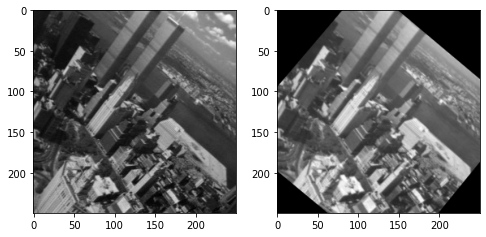

In [25]:
newyork_a_wrapped = cv2.warpPerspective(newyork_a, ny_H, (newyork_a.shape[1], newyork_a.shape[0]))

fig, axes = plt.subplots(1, 2, figsize=(8, 5))

axes[0].imshow(newyork_b, cmap="gray")
axes[1].imshow(newyork_a_wrapped, cmap="gray")

In [26]:
graf_a = readGrayF64("./assigments/assigment4/data/graf/graf_a.jpg")
graf_b = readGrayF64("./assigments/assigment4/data/graf/graf_b.jpg")
graf_a.shape, graf_b.shape

((640, 800), (640, 800))

In [27]:
g_points = np.loadtxt("./assigments/assigment4/data/graf/graf.txt")
g_pointsA = list(zip(g_points[:, 1], g_points[:, 0]))
g_pointsB = list(zip(g_points[:, 3], g_points[:, 2]))

In [28]:
g_H = estimate_homography(g_pointsA, g_pointsB)
g_H

array([[ 1.27437554e+00,  3.43710625e-02,  6.81319745e+01],
       [ 2.23945482e-01,  1.21445700e+00, -7.64078762e+01],
       [ 5.99335420e-04,  4.25744503e-05,  1.00000000e+00]])

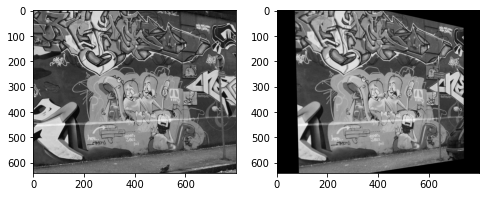

In [29]:
graf_A_wrapped = cv2.warpPerspective(graf_a, g_H, (graf_a.shape[1], graf_a.shape[0]))

fig, axes = plt.subplots(1, 2, figsize=(8, 5))

axes[0].imshow(graf_b, cmap="gray")
axes[1].imshow(graf_A_wrapped, cmap="gray")

#### B

In [30]:
ny_pointsA, ny_pointsB = find_matches(newyork_a, newyork_b, o=4, t=10**-8, nb=10)
len(ny_pointsA), len(ny_pointsB)

(46, 46)

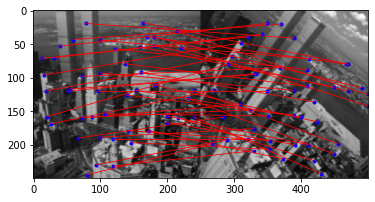

In [31]:
display_matches(newyork_a, ny_pointsA, newyork_b, ny_pointsB)
# we can clearly see that some points are very good matches, but some are terrible (for example short line at the top middle of the image)

In [32]:
def euclidian(x1, y1, x2, y2):
    return np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

def inliers(pointsA, pointsB, H, t):
    points_idx = []
    perror = 0
    for i in range(len(pointsA)):
        # point: [y, x] --> [x, y, 1]
        v = np.matmul(H, [pointsA[i][1], pointsA[i][0], 1]) 
        v = v / v[-1]

        err = euclidian(v[0], v[1], pointsB[i][1], pointsB[i][0])
        perror += err
        if err < t:
            points_idx.append(i)
    return points_idx, perror / len(pointsA)

def ransac(pointsA, pointsB, k=4, samples=4, t=0.001, p=0.99, e=0.1, expected_err=5, estimatior=estimate_homography):
    # subtask C*
    if k is None:
        # 1 - p = (1 - (1 - e)**samples)**k
        # (1 - e)**samples --> probability of all samples being inliers
        # 1 - (1 - e)**samples --> probability of at least one sample being an outlier
        # (1 - (1 - e)**samples)**k --> probability of all k samples having at least one outlier
        # 1 - p --> probability of drawing k samples with all of them having at least one outlier
        k = np.ceil(np.log(1 - p) / np.log(1 - (1 - e)**samples)).astype(int)
        print(f"Automatically detetmined k = {k} using p = {p}, e = {e} and samples = {samples}")

    options = range(len(pointsA))
    k_match_sets = set()
    while len(k_match_sets) < k:
        k_match_sets.add(tuple(sample(options, samples)))

    best_inliers = []
    best_H = None
    best_perror = None
    for matches in k_match_sets:
        H = estimatior(np.take(pointsA, matches, axis=0), np.take(pointsB, matches, axis=0))

        inliers_idx, _ = inliers(pointsA, pointsB, H, t)
        if len(inliers_idx) > len(pointsA) * 0.5:
            H = estimatior(np.take(pointsA, inliers_idx, axis=0), np.take(pointsB, inliers_idx, axis=0))
            _, perror = inliers(pointsA, pointsB, H, t)
            if best_perror is None or perror < best_perror:
                best_perror = perror
                best_H = H
                best_inliers = inliers_idx
                # subtask C*
                # add break condition if a sufficient match is found
                if best_perror < expected_err:
                    break
    return best_H, best_inliers, best_perror


In [33]:
seed(10000) # seed 200 with k = 10 works well
H, inliers_idx, perror = ransac(ny_pointsA, ny_pointsB, k=100, t=20)
perror, len(inliers_idx)

(9.839511851126794, 37)

In [34]:
H

array([[ 7.37014855e-01, -6.30870164e-01,  1.12051637e+02],
       [ 6.34926201e-01,  7.97013200e-01, -3.64269955e+01],
       [-8.40595121e-06,  7.75090357e-05,  1.00000000e+00]])

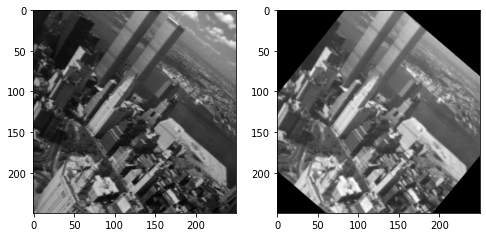

In [35]:
ny_wrapped = cv2.warpPerspective(newyork_a, H, (newyork_a.shape[1], newyork_a.shape[0]))

fig, axes = plt.subplots(1, 2, figsize=(8, 5))

axes[0].imshow(newyork_b, cmap="gray")
axes[1].imshow(ny_wrapped, cmap="gray")

A good solution could be found in as little of 100 iterations but it imporved with more iterations.

Quality increases with more iterations of RANSAC but only slightly and it takes considerable time to run. We want to be strict with out keypoint matching as this will result in less outliers and will thus require less RANSAC iterations to find a good solution.

#### C

In [36]:
H, inliers_idx, perror = ransac(ny_pointsA, ny_pointsB, k=None, t=20, p=0.99, e=0.5, expected_err=10)
perror, len(inliers_idx)

Automatically detetmined k = 72 using p = 0.99, e = 0.5 and samples = 4


(9.880919459017887, 37)

In [37]:
H

array([[ 8.22840199e-01, -6.62788356e-01,  1.15387793e+02],
       [ 7.12755877e-01,  8.96807058e-01, -4.77226938e+01],
       [ 3.00821764e-04,  3.76255050e-04,  1.00000000e+00]])

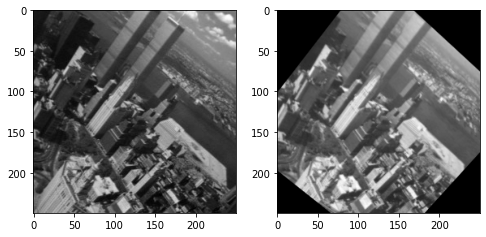

In [38]:
ny_wrapped = cv2.warpPerspective(newyork_a, H, (newyork_a.shape[1], newyork_a.shape[0]))

fig, axes = plt.subplots(1, 2, figsize=(8, 5))

axes[0].imshow(newyork_b, cmap="gray")
axes[1].imshow(ny_wrapped, cmap="gray")

#### D

In [39]:
def scaled_point(point):
    s = 1
    if len(point) > 2:
        s = point[2]
    return (point[0] / s, point[1] / s)

def points_matrices(pointsA, pointsB):
    Amatrix = np.zeros((2*len(pointsA), 8))
    Bmatrix = np.zeros((2*len(pointsB), 1))

    for i in range(len(pointsA)):
        yA, xA = scaled_point(pointsA[i])
        yB, xB = scaled_point(pointsB[i])
        
        Bmatrix[2*i] = xB
        Bmatrix[2*i +1] = yB

        Amatrix[2*i] = [xA, yA, 1, 0, 0, 0, -xB*xA, -xB*yA]
        Amatrix[2*i +1] = [0, 0, 0, xA, yA, 1, -yB*xA, -yB*yA]
    
    return Amatrix, Bmatrix

def weighted_least_squares(A, B, W):
    # we want to solve A @ H = B for H
    # we also have weights W
    # W * A @ H = W * B
    nA = np.multiply(W, A)
    nB = np.multiply(W, B)

    # because A is not square, we need multiply both sides by A.T
    # A.T @ W * A @ H = A.T @ W * B
    nA = A.T @ nA
    nB = A.T @ nB
    
    # we don't want to calculate inverses as it might lead to numerical errors
    # we can avoid that by calculation QR decomposition
    Q, R = np.linalg.qr(nA)

    # we can now solve modified upper triangular system (Q is orthogonal thus Q.T @ Q = I)
    # R @ H = Q.T @ nB
    # which is done by back substitution and is thus numerically stable and efficient
    P = solve_triangular(R, Q.T @ nB, lower=False)
    return P

def transform_error(A, B, P, W):
    # e = (A @ P - B) # error
    # e = e**2 # squared error
    # e = W * e # weighted error
    e = W * (A @ P - B)**2
    return e
    

def reweighted_least_squares(pointsA, pointsB, k=5, per_element_error_th=0.1):
    Amatrix, Bmatrix = points_matrices(pointsA, pointsB)
    weights = np.ones((2*len(pointsA), 1))
    for _ in range(k):
        P = weighted_least_squares(Amatrix, Bmatrix, weights)
        errors = transform_error(Amatrix, Bmatrix, P, weights)
        errors[errors <= 10**-6] = 10**-6
        weights = errors**-1
        if np.mean(errors) < per_element_error_th * 2*len(pointsA): 
            break
    P = np.append(P, [[1]], axis=0)
    H = P.reshape((3, 3))
    return H
    

In [40]:
seed(200)
best_H_rls, best_inliers, best_perror = ransac(ny_pointsA, ny_pointsB, k=200, samples=5, t=20, estimatior=reweighted_least_squares)
best_H_rls, best_perror, len(best_inliers)

(array([[ 7.98456005e-01, -6.40933895e-01,  1.10267919e+02],
        [ 6.90268806e-01,  8.27176658e-01, -4.18715679e+01],
        [ 2.36233752e-04,  9.47238168e-05,  1.00000000e+00]]),
 9.694795055712321,
 37)

In [41]:
seed(200)
best_H_eh, best_inliers, best_perror = ransac(ny_pointsA, ny_pointsB, k=800, t=20, estimatior=estimate_homography)
best_H_eh, best_perror, len(best_inliers)

(array([[ 7.98885426e-01, -6.48847617e-01,  1.14061580e+02],
        [ 7.02846858e-01,  8.85672211e-01, -4.74680715e+01],
        [ 1.92521766e-04,  3.24570580e-04,  1.00000000e+00]]),
 9.817781814769788,
 35)

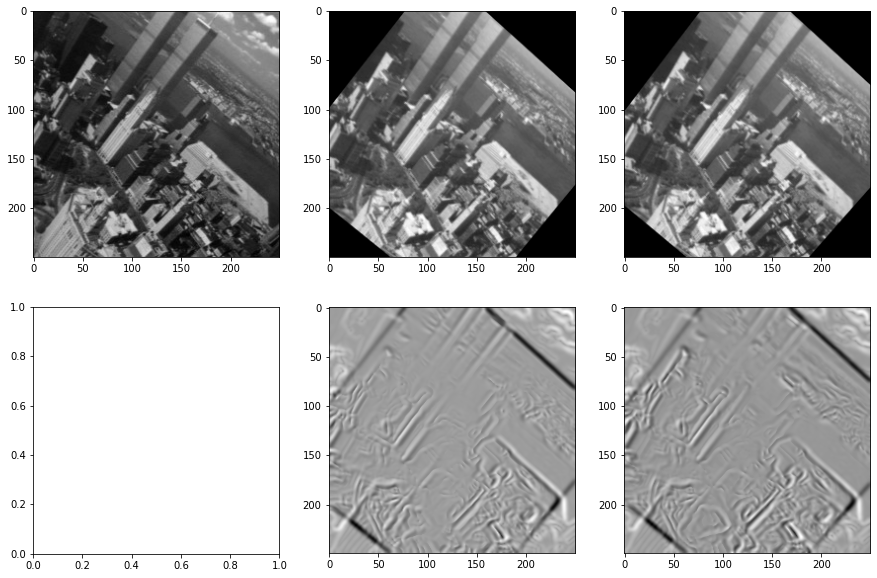

In [42]:
ny_wrapped_eh = cv2.warpPerspective(newyork_a, best_H_eh, (newyork_a.shape[1], newyork_a.shape[0]))
ny_wrapped_lrs = cv2.warpPerspective(newyork_a, best_H_rls, (newyork_a.shape[1], newyork_a.shape[0]))

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0, 0].imshow(newyork_b, cmap="gray")
axes[0, 1].imshow(ny_wrapped_lrs, cmap="gray")
axes[0, 2].imshow(ny_wrapped_eh, cmap="gray")

magnitude = lambda x: np.sqrt(imgDX(x)**2 + imgDY(x)**2)

axes[1, 1].imshow(- magnitude(ny_wrapped_lrs) + magnitude(newyork_b), cmap="gray")
axes[1, 2].imshow(- magnitude(ny_wrapped_eh) + magnitude(newyork_b), cmap="gray")

#### E

In [43]:
def apply_homography(I, H):
    Iw = np.zeros_like(I)

    Hi = np.linalg.pinv(H)
    for y in range(Iw.shape[0]):
        for x in range(Iw.shape[1]):
            p = Hi @ np.array([x, y, 1])
            p = p / p[2]
            p = np.round(p).astype(int)
            x1, y1 = p[0], p[1]
            if x1 >= 0 and x1 < I.shape[1] and y1 >= 0 and y1 < I.shape[0]:
                Iw[y, x] = I[y1, x1]

    return Iw


In [44]:
ny_wrapped_custom = apply_homography(newyork_a, best_H_rls)

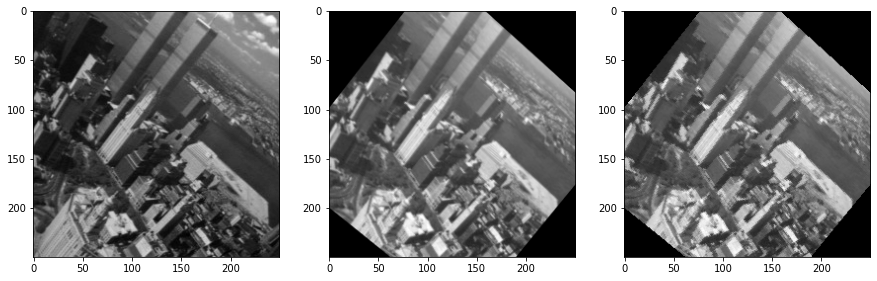

In [45]:
fig, axes = plt.subplots(1, 3, figsize=(15, 10))

axes[0].imshow(newyork_b, cmap="gray")

axes[1].imshow(ny_wrapped_lrs, cmap="gray")

axes[2].imshow(ny_wrapped_custom, cmap="gray")

Determinant of transform matrix: 0.0


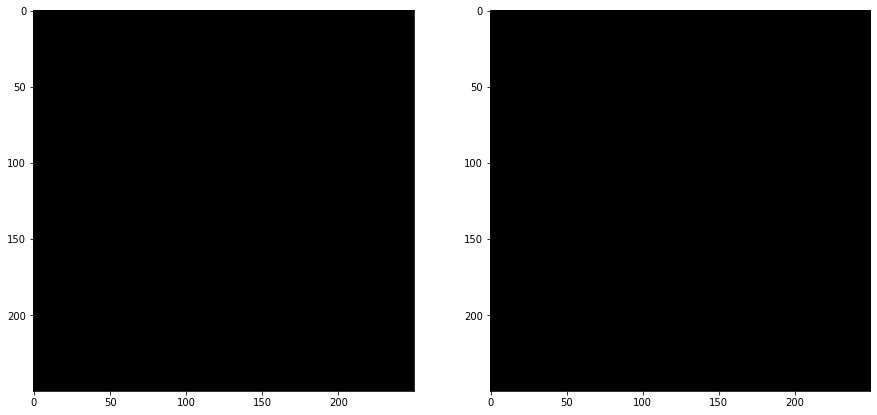

In [46]:
transform_matrix = np.array([[0.1, -0.4, 60], [-0.2, 0.8, -52], [0, 0, 1]]).astype(float)
# transform_matrix = best_H_rls

print("Determinant of transform matrix:", np.linalg.det(transform_matrix))

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes[0].imshow(apply_homography(newyork_a, transform_matrix), cmap="gray")

axes[1].imshow(cv2.warpPerspective(newyork_a, transform_matrix, (newyork_a.shape[1], newyork_a.shape[0])), cmap="gray")

### SIFT

In [47]:
import sift
import importlib
importlib.reload(sift)
Sift = sift.Sift

In [48]:
eiffel_tower = readGrayF64("./assigments/assigment4/data/eiffel_tower.jpg")
eiffel_tower = cv2.resize(eiffel_tower, (0, 0), fx=0.5, fy=0.5)
eiffel_tower.shape

(800, 600)

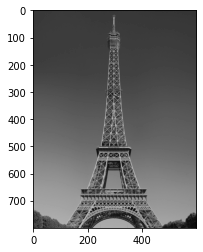

In [49]:
plt.imshow(eiffel_tower, cmap="gray")

In [50]:
levels = 10
sigma = 1.6
sift = Sift(octaves=1, levels=levels, sigma0=sigma, sigmaS=1.2)
sift.load_image(eiffel_tower)

In [51]:
pyramid = sift._dog_pyramid()
pyramid.shape

(10, 800, 600)

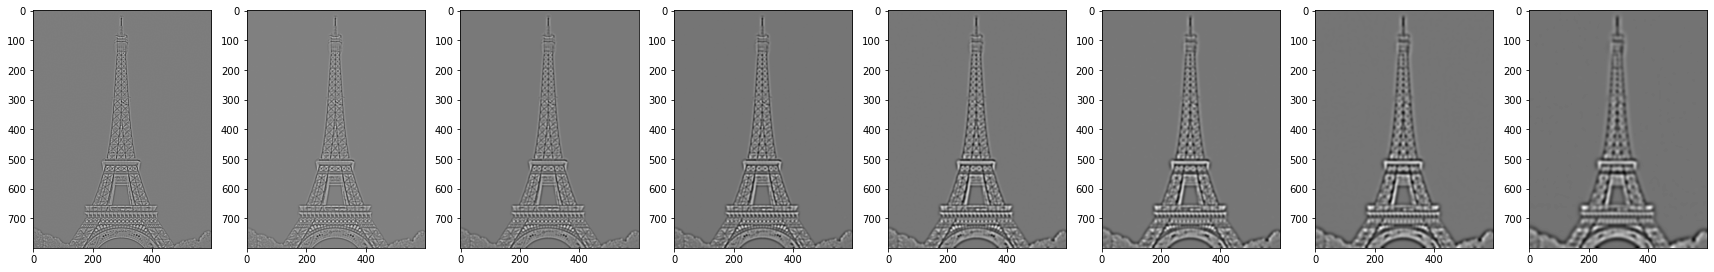

In [52]:
plots = 8
fig, axes = plt.subplots(1, plots, figsize=(30, 10))

for i in range(plots):
    axes[i].imshow(pyramid[i], cmap="gray")

In [53]:
def visulize_keypoints(img, keypoints):
    _ = plt.figure(figsize=(10, 10))
    plt.imshow(img, cmap="gray")
    plt.scatter(keypoints[:, 2], keypoints[:, 1], s=10 * sigma ** keypoints[:, 0], fc='none', ec='r')
    
    if keypoints.shape[1] > 3:
        U = np.cos(keypoints[:, 3])
        V = np.sin(keypoints[:, 3])
        S = 2 / keypoints[:, 4]
        plt.quiver(keypoints[:, 2], keypoints[:, 1], U, V, angles='xy', color='y', scale=S, headwidth=1, width=0.0025)

In [54]:
pyramid_maxima = sift._maxima_in_scale_space(pyramid)
initial_keypoints = np.argwhere(pyramid_maxima)
len(initial_keypoints)

925

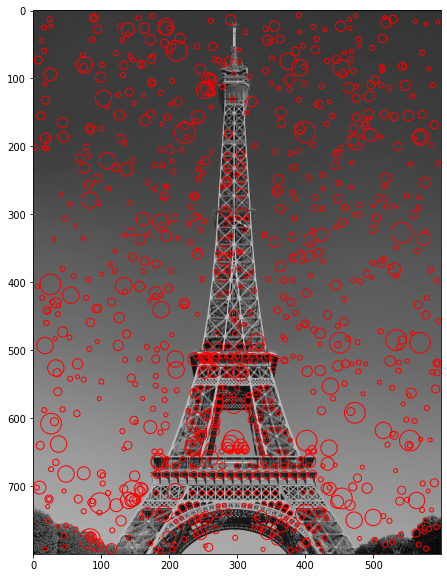

In [55]:
visulize_keypoints(eiffel_tower, initial_keypoints)

In [56]:
keypoints_s = sift._reject_weak_points(initial_keypoints, 0.03)
len(keypoints_s)

315

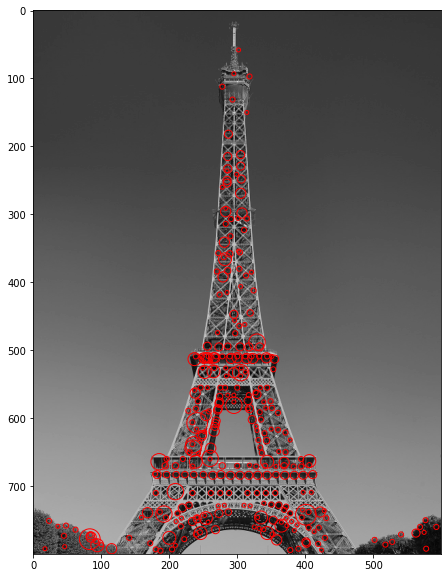

In [57]:
visulize_keypoints(eiffel_tower, keypoints_s)

In [58]:
hr = sift._harris_response()
hr.max(), hr.min(), hr.mean()

(2.4248917770755885, -0.816962585731846, 0.02525781663938967)

In [59]:
keypoints = sift._reject_edge_points(keypoints_s, 0.025)
len(keypoints)

141

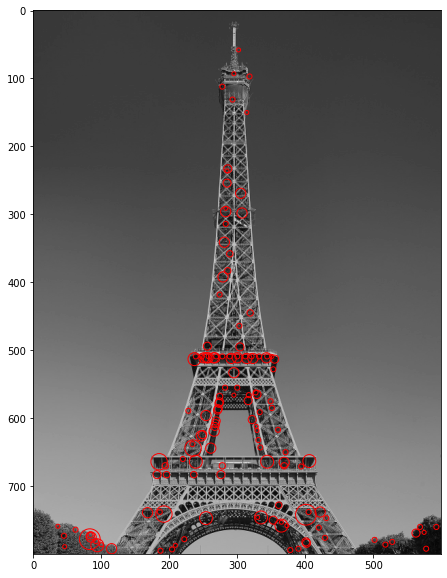

In [60]:
visulize_keypoints(eiffel_tower, keypoints)

In [61]:
keypoints_o = sift._get_orientations(keypoints)

In [62]:
len(keypoints_o)

264

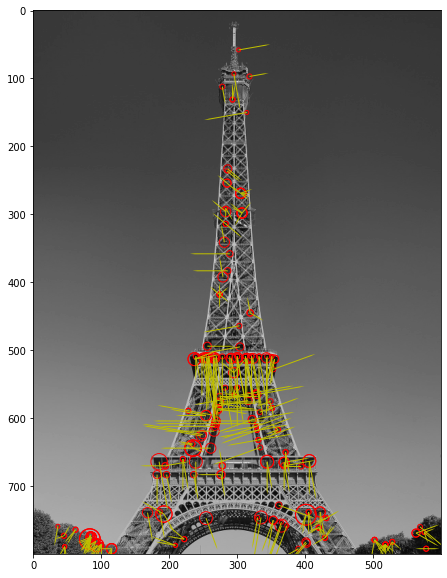

In [63]:
visulize_keypoints(eiffel_tower, keypoints_o)

In [64]:
eiffel_tower_descriptors, keypoints_o_f = sift.describe(keypoints_o)

In [65]:
eiffel_tower_descriptors[0].shape, len(keypoints_o_f), len(keypoints_o)

((128,), 237, 264)

In [66]:
eiffel_tower_smaller = readGrayF64("./assigments/assigment4/data/eiffel_tower_smaller.jpg")
eiffel_tower_smaller.shape

(980, 980)

In [67]:
sift.load_image(eiffel_tower_smaller)
ets_keypoints = sift.detect_keypoints(0.03, 0.025)
len(ets_keypoints)

2005

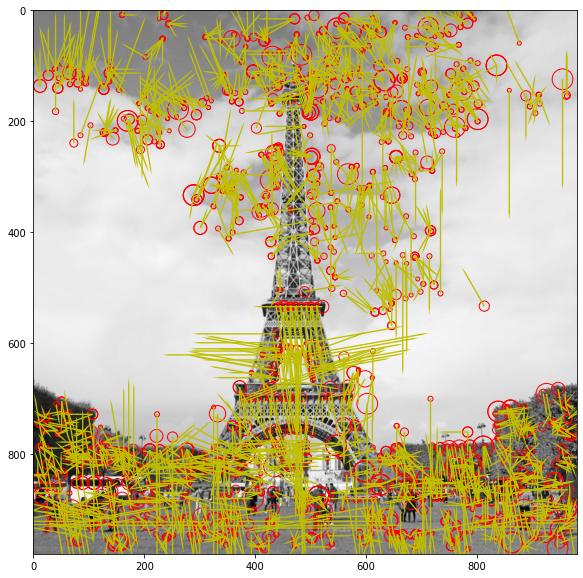

In [68]:
visulize_keypoints(eiffel_tower_smaller, ets_keypoints)

In [69]:
eiffel_tower_rotated = readGrayF64("./assigments/assigment4/data/eiffel_tower_rotated.jpg")
eiffel_tower_rotated = cv2.resize(eiffel_tower_rotated, (0, 0), fx=0.75, fy=0.75)
sift.load_image(eiffel_tower_rotated)
eiffel_tower_rotated.shape

(600, 900)

In [70]:
sift.load_image(eiffel_tower_rotated)
etr_keypoints = sift.detect_keypoints(0.03, 0.025)
len(etr_keypoints)

486

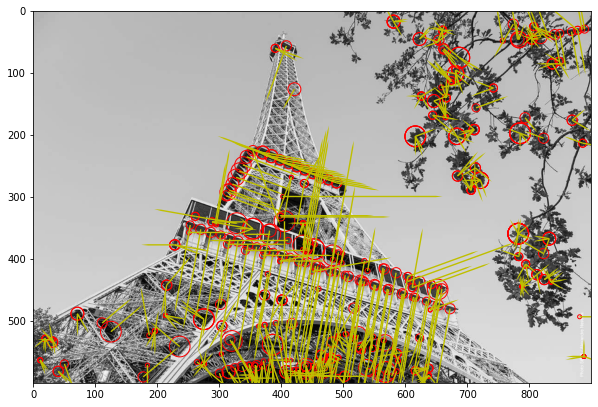

In [71]:
visulize_keypoints(eiffel_tower_rotated, etr_keypoints)

In [72]:
len(ets_keypoints)

2005

In [73]:
efs_descriptors, ets_keypoints_f = sift.describe(ets_keypoints)

In [74]:
efs_descriptors[0].shape, len(ets_keypoints_f), len(ets_keypoints)

((128,), 709, 2005)

In [75]:
len(eiffel_tower_descriptors), len(efs_descriptors)

(237, 709)

In [76]:
corr_et_ets = find_correspondences(eiffel_tower_descriptors, efs_descriptors)

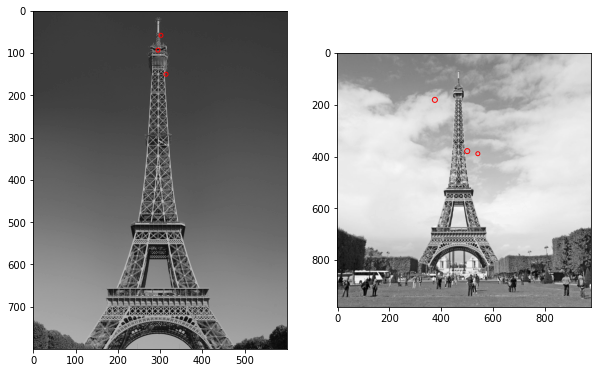

In [77]:
N = 3
fig, axes = plt.subplots(1, 2, figsize=(10, 10))

axes[0].imshow(eiffel_tower, cmap="gray")
axes[1].imshow(eiffel_tower_smaller, cmap="gray")

for i in range(N):
    matched_et = keypoints_o_f[corr_et_ets[i][0]]
    axes[0].scatter(matched_et[2], matched_et[1], s=10 * sigma ** matched_et[0], fc='none', ec='r')

    matched_etr = ets_keypoints_f[corr_et_ets[i][1]]
    axes[1].scatter(matched_etr[2], matched_etr[1], s=10 * sigma ** matched_etr[0], fc='none', ec='r')
